# Ethereum Code Chunking Analysis

This notebook analyzes code chunking patterns on Ethereum mainnet to understand:
- How much of contract bytecode is actually accessed during execution
- Chunk utilization patterns across different contracts
- Relationships between contract characteristics and access patterns

## Dataset Schema
- `block_number`: Block number on Ethereum mainnet
- `address`: Contract address
- `bytecode_size`: Total size of the contract code
- `bytes_count`: Number of bytes accessed
- `chunks_count`: Number of chunks accessed
- `code_ops_count`: Number of code-related operations (EXTCODESIZE, EXTCODECOPY, EXTCODEHASH, CODECOPY, CODESIZE)

**Note**: Total chunks = bytecode_size / 32 (chunks are 32 bytes each)

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully")

Libraries imported successfully


## 1. Data Loading and Initial Exploration

In [164]:
# Load both datasets and merge them
data_files = ['../results/analysis-0.csv', '../results/analysis-1.csv']
dataframes = []

for file_path in data_files:
    try:
        df_temp = pd.read_csv(file_path)
        print(f"Loaded {file_path}: {df_temp.shape}")
        dataframes.append(df_temp)
    except FileNotFoundError:
        print(f"Warning: {file_path} not found, skipping...")

# Merge all dataframes
df = pd.concat(dataframes, ignore_index=True)

print(f"\nCombined dataset shape: {df.shape}")
print(f"\nDataset info:")
print(df.info())
print(f"\nFirst few rows:")
df.head(10)

Loaded ../results/analysis-0.csv: (1252832, 6)
Loaded ../results/analysis-1.csv: (1207497, 6)

Combined dataset shape: (2460329, 6)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2460329 entries, 0 to 2460328
Data columns (total 6 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   block_number    int64 
 1   address         object
 2   bytecode_size   int64 
 3   bytes_count     int64 
 4   chunks_count    int64 
 5   code_ops_count  int64 
dtypes: int64(5), object(1)
memory usage: 112.6+ MB
None

First few rows:


,block_number,address,bytecode_size,bytes_count,chunks_count,code_ops_count
0,22000000,0x8ad599c3A0ff1De082011EFDDc58f1908eb6e6D8,22142,5136,215,1
1,22000000,0x85a471E728F8F0932694d349993DC9A599a5978c,19080,2394,93,0
2,22000000,0x5Ebac8dbfbBA22168471b0f914131d1976536A25,11329,2762,114,0
3,22000000,0x4512759606F9e680361dD76c4C17f92031De7AcD,15159,1209,54,6
4,22000000,0x4C19596f5aAfF459fA38B0f7eD92F11AE6543784,2700,143,6,2
5,22000000,0x8CC51c532f5A71210D19d87D3d8a1E6F50AD583c,2112,283,16,0
6,22000000,0x1008FAbD07aBd93a7D9bB81803a89cC3a834E1A9,7265,2305,104,0
7,22000000,0xF0262815AA54aEa5D9EEc6eA09937C6723b7Bd21,6164,316,16,0
8,22000000,0x68d30f47F19c07bCCEf4Ac7FAE2Dc12FCa3e0dC9,170,103,4,0
9,22000000,0x5141B82f5fFDa4c6fE1E372978F1C5427640a190,17346,2012,82,1


In [165]:
# Basic statistics
print("Basic Statistics:")
print(df.describe())

print(f"\nUnique blocks: {df['block_number'].nunique()}")
print(f"Unique addresses: {df['address'].nunique()}")
print(f"Total records: {len(df)}")

Basic Statistics:
       block_number  bytecode_size   bytes_count  chunks_count  code_ops_count
count  2.460329e+06   2.460329e+06  2.460329e+06  2.460329e+06    2.460329e+06
mean   2.200501e+07   8.768761e+03  1.484269e+03  6.381641e+01    1.638204e+00
std    2.919531e+03   8.049675e+03  1.848794e+03  7.346462e+01    1.054320e+01
min    2.200000e+07   3.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00
25%    2.200248e+07   1.654000e+03  2.170000e+02  1.100000e+01    0.000000e+00
50%    2.200490e+07   6.635000e+03  7.160000e+02  3.500000e+01    0.000000e+00
75%    2.200759e+07   1.393600e+04  2.097000e+03  9.400000e+01    1.000000e+00
max    2.201000e+07   2.457600e+04  2.285500e+04  7.180000e+02    2.176000e+03

Unique blocks: 9993
Unique addresses: 324127
Total records: 2460329


## 2. Data Cleaning

In [166]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check for empty rows (all NaN)
empty_rows = df.isnull().all(axis=1).sum()
print(f"\nEmpty rows: {empty_rows}")

# Remove any empty rows
df_clean = df.dropna(how='all')
print(f"Shape after removing empty rows: {df_clean.shape}")

Missing values per column:
block_number      0
address           0
bytecode_size     0
bytes_count       0
chunks_count      0
code_ops_count    0
dtype: int64

Empty rows: 0
Shape after removing empty rows: (2460329, 6)


In [167]:
# Check for duplicate (block_number, address) combinations
duplicates = df_clean.duplicated(subset=['block_number', 'address']).sum()
print(f"Duplicate block_number + address combinations: {duplicates}")

if duplicates > 0:
    print("\nDuplicate entries:")
    duplicate_mask = df_clean.duplicated(subset=['block_number', 'address'], keep=False)
    print(df_clean[duplicate_mask].sort_values(['block_number', 'address']))
    
    # Keep first occurrence of duplicates
    df_clean = df_clean.drop_duplicates(subset=['block_number', 'address'], keep='first')
    print(f"\nShape after removing duplicates: {df_clean.shape}")
else:
    print("No duplicates found - data is clean!")

Duplicate block_number + address combinations: 8

Duplicate entries:
       block_number                                     address  \
95968      22000464  0x0190a2328e072Fc5a7fA00F6C9ae2a16c7F4E32a   
96110      22000464  0x0190a2328e072Fc5a7fA00F6C9ae2a16c7F4E32a   
95978      22000464  0x1CfdeB61648C157e438D3C34455D6001a0F5ca6F   
96113      22000464  0x1CfdeB61648C157e438D3C34455D6001a0F5ca6F   
95882      22000464  0x2054Df898bB8CCbF532eCF067291D994a8a9Dc8A   
96109      22000464  0x2054Df898bB8CCbF532eCF067291D994a8a9Dc8A   
96103      22000464  0x49fb8ad7578148E17c3eF0C344CE23A66ed372C4   
96111      22000464  0x49fb8ad7578148E17c3eF0C344CE23A66ed372C4   
95896      22000464  0x54D2252757e1672EEaD234D27B1270728fF90581   
96108      22000464  0x54D2252757e1672EEaD234D27B1270728fF90581   
95989      22000464  0x5D4Aa78B08Bc7C530e21bf7447988b1Be7991322   
96115      22000464  0x5D4Aa78B08Bc7C530e21bf7447988b1Be7991322   
95983      22000464  0x807cF9A772d5a3f9CeFBc1192e939D62f0D9b

In [168]:
# Check for any data quality issues
print("Data Quality Checks:")
print(f"Records with bytecode_size = 0: {(df_clean['bytecode_size'] == 0).sum()}")
print(f"Records with bytes_count > bytecode_size: {(df_clean['bytes_count'] > df_clean['bytecode_size']).sum()}")

# Check block range (should include blocks 22000000 to 22010000 inclusive)
print(f"\nBlock Range Analysis:")
print(f"Block range in data: {df_clean['block_number'].min()} - {df_clean['block_number'].max()}")
print(f"Expected range: 22000000 - 22010000")

# Validate expected block range
expected_min_block = 22000000
expected_max_block = 22010000
actual_min_block = df_clean['block_number'].min()
actual_max_block = df_clean['block_number'].max()

blocks_in_expected_range = df_clean[
    (df_clean['block_number'] >= expected_min_block) & 
    (df_clean['block_number'] <= expected_max_block)
]

print(f"\nBlock Range Validation:")
print(f"Records in expected range (22000000-22010000): {len(blocks_in_expected_range)} ({len(blocks_in_expected_range)/len(df_clean)*100:.1f}%)")

# Detailed block analysis
expected_block_count = expected_max_block - expected_min_block + 1
actual_unique_blocks = df_clean['block_number'].nunique()
print(f"\nDetailed Block Analysis:")
print(f"Expected total blocks: {expected_block_count:,}")
print(f"Actual unique blocks: {actual_unique_blocks:,}")
print(f"Missing blocks: {expected_block_count - actual_unique_blocks}")

if expected_block_count != actual_unique_blocks:
    # Find missing blocks
    expected_blocks = set(range(expected_min_block, expected_max_block + 1))
    actual_blocks = set(df_clean['block_number'].unique())
    missing_blocks = sorted(expected_blocks - actual_blocks)
    
    print(f"\n❌ Missing blocks ({len(missing_blocks)}):")
    if len(missing_blocks) <= 20:  # Only show if reasonable number
        print(f"   {missing_blocks}")
    else:
        print(f"   First 10: {missing_blocks[:10]}")
        print(f"   Last 10: {missing_blocks[-10:]}")
        
    # Check for any blocks outside expected range
    extra_blocks = sorted(actual_blocks - expected_blocks)
    if extra_blocks:
        print(f"\n⚠️  Blocks outside expected range ({len(extra_blocks)}):")
        if len(extra_blocks) <= 20:
            print(f"   {extra_blocks}")
        else:
            print(f"   First 10: {extra_blocks[:10]}")
            print(f"   Last 10: {extra_blocks[-10:]}")

if actual_min_block < expected_min_block or actual_max_block > expected_max_block:
    print(f"⚠️  Warning: Data contains blocks outside expected range")
    
if len(blocks_in_expected_range) == 0:
    print(f"❌ Error: No blocks found in expected range!")
else:
    print(f"✅ Data contains blocks in expected range")

# Block coverage statistics
block_counts = df_clean['block_number'].value_counts().sort_index()
print(f"\nBlock Coverage Statistics:")
print(f"Min contracts per block: {block_counts.min()}")
print(f"Max contracts per block: {block_counts.max()}")
print(f"Median contracts per block: {block_counts.median():.1f}")
print(f"Blocks with 0 contracts: {expected_block_count - actual_unique_blocks}")
print("Missing blocks have 0 contract-related transactions (manually checked)")

# Show distribution of contracts per block
print(f"\nContract Distribution Summary:")
print(f"Blocks with <100 contracts: {(block_counts < 100).sum()}")
print(f"Blocks with 100-500 contracts: {((block_counts >= 100) & (block_counts < 500)).sum()}")
print(f"Blocks with 500+ contracts: {(block_counts >= 500).sum()}")

# Remove records with bytecode_size = 0 as they're not meaningful for analysis
df_clean = df_clean[df_clean['bytecode_size'] > 0]
print(f"\nFinal cleaned dataset shape: {df_clean.shape}")

# Additional validation for large dataset
print(f"\nDataset Scale:")
print(f"Total contracts: {len(df_clean):,}")
print(f"Unique addresses: {df_clean['address'].nunique():,}")
print(f"Average contracts per block: {len(df_clean) / df_clean['block_number'].nunique():.1f}")

Data Quality Checks:
Records with bytecode_size = 0: 0
Records with bytes_count > bytecode_size: 0

Block Range Analysis:
Block range in data: 22000000 - 22010000
Expected range: 22000000 - 22010000

Block Range Validation:
Records in expected range (22000000-22010000): 2460321 (100.0%)

Detailed Block Analysis:
Expected total blocks: 10,001
Actual unique blocks: 9,993
Missing blocks: 8

❌ Missing blocks (8):
   [22000150, 22000719, 22001061, 22002405, 22004951, 22006220, 22006786, 22006898]
✅ Data contains blocks in expected range

Block Coverage Statistics:
Min contracts per block: 3
Max contracts per block: 649
Median contracts per block: 239.0
Blocks with 0 contracts: 8
Missing blocks have 0 contract-related transactions (manually checked)

Contract Distribution Summary:
Blocks with <100 contracts: 805
Blocks with 100-500 contracts: 9072
Blocks with 500+ contracts: 116

Final cleaned dataset shape: (2460321, 6)

Dataset Scale:
Total contracts: 2,460,321
Unique addresses: 324,127
Av

## 3. Feature Engineering - Calculate Key Metrics

In [169]:
# Calculate derived metrics
df_analysis = df_clean.copy()

# Calculate total chunks (bytecode_size / 32)
df_analysis['total_chunks'] = np.ceil(df_analysis['bytecode_size'] / 32).astype(int)

# Calculate proportions (main research questions)
df_analysis['bytes_accessed_ratio'] = df_analysis['bytes_count'] / df_analysis['bytecode_size']
df_analysis['chunks_accessed_ratio'] = df_analysis['chunks_count'] / df_analysis['total_chunks']

# Additional metrics for deeper analysis
df_analysis['avg_bytes_per_chunk'] = df_analysis['bytes_count'] / df_analysis['chunks_count']
df_analysis['code_ops_per_byte'] = df_analysis['code_ops_count'] / df_analysis['bytecode_size']

# Contract size categories
size_category_labels = ['Tiny (<1KiB)', 'Small (1-5KiB)', 'Medium (5-10KiB)', 
                        'Large (10-20KiB)', 'Very Large (20-24KiB)', 'Max (24KiB)']
df_analysis['size_category'] = pd.cut(df_analysis['bytecode_size'], 
                                     bins=[0, 1023, 5119, 10239, 20479, 24575, float('inf')],
                                     labels=size_category_labels)

print("Calculated metrics:")
print(df_analysis[['bytes_accessed_ratio', 'chunks_accessed_ratio', 'total_chunks', 'avg_bytes_per_chunk']].describe())

print(f"\nContract size distribution:")
print(df_analysis['size_category'].value_counts())

Calculated metrics:
       bytes_accessed_ratio  chunks_accessed_ratio  total_chunks  \
count          2.460321e+06           2.460321e+06  2.460321e+06   
mean           3.000115e-01           3.681864e-01  2.744969e+02   
std            2.959514e-01           2.938890e-01  2.515054e+02   
min            0.000000e+00           0.000000e+00  1.000000e+00   
25%            1.017159e-01           1.666667e-01  5.200000e+01   
50%            1.927932e-01           2.727273e-01  2.080000e+02   
75%            3.320520e-01           4.615385e-01  4.360000e+02   
max            1.000000e+00           1.000000e+00  7.680000e+02   

       avg_bytes_per_chunk  
count         2.459328e+06  
mean          2.192306e+01  
std           3.249111e+00  
min           1.000000e+00  
25%           1.963636e+01  
50%           2.200000e+01  
75%           2.442105e+01  
max           3.200000e+01  

Contract size distribution:
size_category
Small (1-5KiB)           622277
Large (10-20KiB)         556996

## 4. Primary Research Questions Analysis

### Question 1: What is the proportion of bytes accessed over bytecode size?

Bytes Accessed Ratio Statistics:
count    2.460321e+06
mean     3.000115e-01
std      2.959514e-01
min      0.000000e+00
25%      1.017159e-01
50%      1.927932e-01
75%      3.320520e-01
max      1.000000e+00
Name: bytes_accessed_ratio, dtype: float64


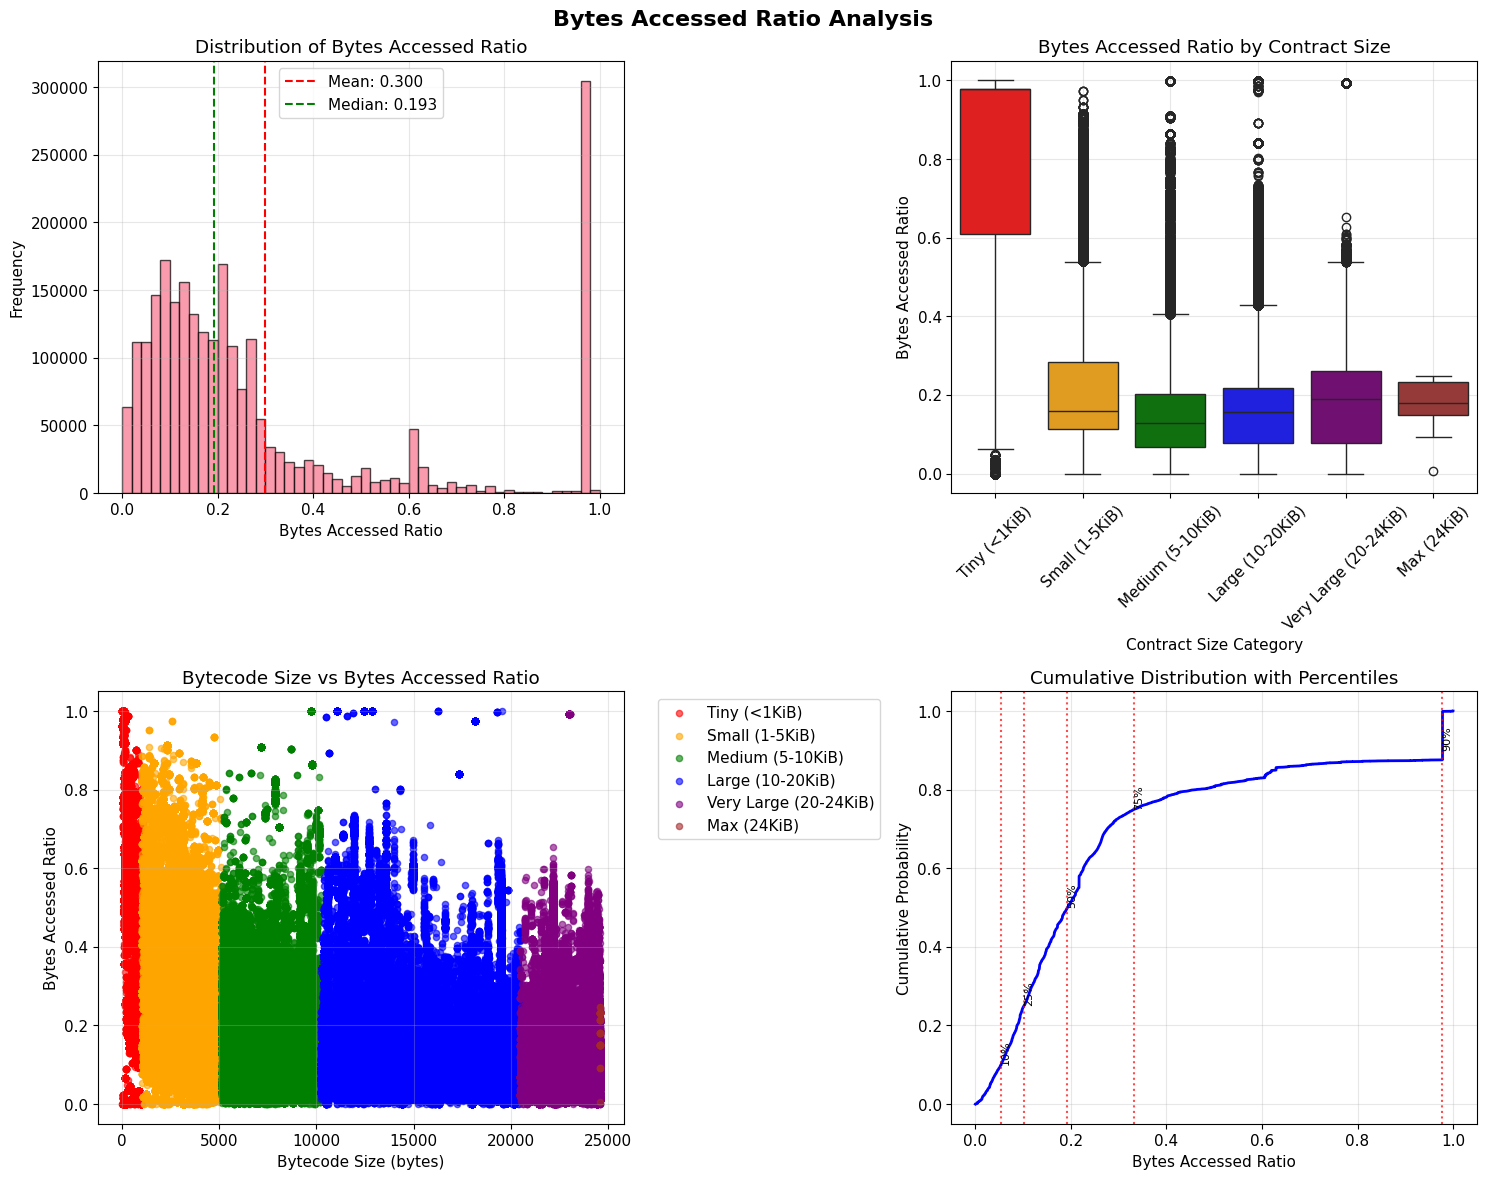


KEY INSIGHTS - Bytes Accessed Ratio:
• Average proportion of bytes accessed: 30.0%
• Median proportion of bytes accessed: 19.3%
• 10th percentile: 5.4%
• 90th percentile: 97.8%
• Contracts with >50% bytes accessed: 474,225 (19.3%)

📊 By Contract Size:
• Tiny (<1KiB): 493,872 contracts, avg 77.9%, median 97.8%
• Small (1-5KiB): 622,277 contracts, avg 21.7%, median 15.9%
• Medium (5-10KiB): 389,900 contracts, avg 15.0%, median 12.7%
• Large (10-20KiB): 556,996 contracts, avg 16.3%, median 15.6%
• Very Large (20-24KiB): 397,220 contracts, avg 17.4%, median 18.8%
• Max (24KiB): 56 contracts, avg 18.6%, median 18.0%


In [174]:
# Analysis of bytes accessed ratio
bytes_ratio_stats = df_analysis['bytes_accessed_ratio'].describe()
print("Bytes Accessed Ratio Statistics:")
print(bytes_ratio_stats)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Bytes Accessed Ratio Analysis', fontsize=16, fontweight='bold')

# Histogram
axes[0,0].hist(df_analysis['bytes_accessed_ratio'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].axvline(bytes_ratio_stats['mean'], color='red', linestyle='--', label=f'Mean: {bytes_ratio_stats["mean"]:.3f}')
axes[0,0].axvline(bytes_ratio_stats['50%'], color='green', linestyle='--', label=f'Median: {bytes_ratio_stats["50%"]:.3f}')
axes[0,0].set_xlabel('Bytes Accessed Ratio')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Bytes Accessed Ratio')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Colored box plot by contract size using seaborn
sns.boxplot(data=df_analysis, x='size_category', y='bytes_accessed_ratio', 
            palette=['red', 'orange', 'green', 'blue', 'purple', 'brown'],
            ax=axes[0,1])
axes[0,1].set_title('Bytes Accessed Ratio by Contract Size')
axes[0,1].set_xlabel('Contract Size Category')
axes[0,1].set_ylabel('Bytes Accessed Ratio')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Scatter plot with color coding by size
size_colors = {size_category_labels[0]: 'red', size_category_labels[1]: 'orange', size_category_labels[2]: 'green', 
               size_category_labels[3]: 'blue', size_category_labels[4]: 'purple', size_category_labels[5]: 'brown'}
for size_cat, color in size_colors.items():
    mask = df_analysis['size_category'] == size_cat
    if mask.any():
        axes[1,0].scatter(df_analysis[mask]['bytecode_size'], 
                         df_analysis[mask]['bytes_accessed_ratio'], 
                         alpha=0.6, label=size_cat, color=color, s=20)

axes[1,0].set_xlabel('Bytecode Size (bytes)')
axes[1,0].set_ylabel('Bytes Accessed Ratio')
axes[1,0].set_title('Bytecode Size vs Bytes Accessed Ratio')
axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,0].grid(True, alpha=0.3)

# Cumulative distribution with percentile markers
sorted_ratios = np.sort(df_analysis['bytes_accessed_ratio'])
y_values = np.arange(1, len(sorted_ratios) + 1) / len(sorted_ratios)
axes[1,1].plot(sorted_ratios, y_values, linewidth=2, color='blue')

# Add percentile markers
percentiles = [10, 25, 50, 75, 90]
for p in percentiles:
    val = np.percentile(df_analysis['bytes_accessed_ratio'], p)
    axes[1,1].axvline(val, color='red', linestyle=':', alpha=0.7)
    axes[1,1].text(val, p/100, f'{p}%', rotation=90, verticalalignment='bottom', fontsize=8)

axes[1,1].set_xlabel('Bytes Accessed Ratio')
axes[1,1].set_ylabel('Cumulative Probability')
axes[1,1].set_title('Cumulative Distribution with Percentiles')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Enhanced insights with contract size breakdown
print(f"\nKEY INSIGHTS - Bytes Accessed Ratio:")
print(f"• Average proportion of bytes accessed: {bytes_ratio_stats['mean']:.1%}")
print(f"• Median proportion of bytes accessed: {bytes_ratio_stats['50%']:.1%}")
print(f"• 10th percentile: {np.percentile(df_analysis['bytes_accessed_ratio'], 10):.1%}")
print(f"• 90th percentile: {np.percentile(df_analysis['bytes_accessed_ratio'], 90):.1%}")
print(f"• Contracts with >50% bytes accessed: {(df_analysis['bytes_accessed_ratio'] > 0.5).sum():,} ({(df_analysis['bytes_accessed_ratio'] > 0.5).mean():.1%})")

# Size-specific insights
print(f"\n📊 By Contract Size:")
size_summary = df_analysis.groupby('size_category')['bytes_accessed_ratio'].agg(['count', 'mean', 'median']).round(3)
for size_cat in size_category_labels:
    if size_cat in size_summary.index:
        count = size_summary.loc[size_cat, 'count']
        mean_ratio = size_summary.loc[size_cat, 'mean']
        median_ratio = size_summary.loc[size_cat, 'median']
        print(f"• {size_cat}: {count:,} contracts, avg {mean_ratio:.1%}, median {median_ratio:.1%}")

### Question 2: What is the proportion of chunks accessed over total chunks?

Chunks Accessed Ratio Statistics:
count    2.460321e+06
mean     3.681864e-01
std      2.938890e-01
min      0.000000e+00
25%      1.666667e-01
50%      2.727273e-01
75%      4.615385e-01
max      1.000000e+00
Name: chunks_accessed_ratio, dtype: float64


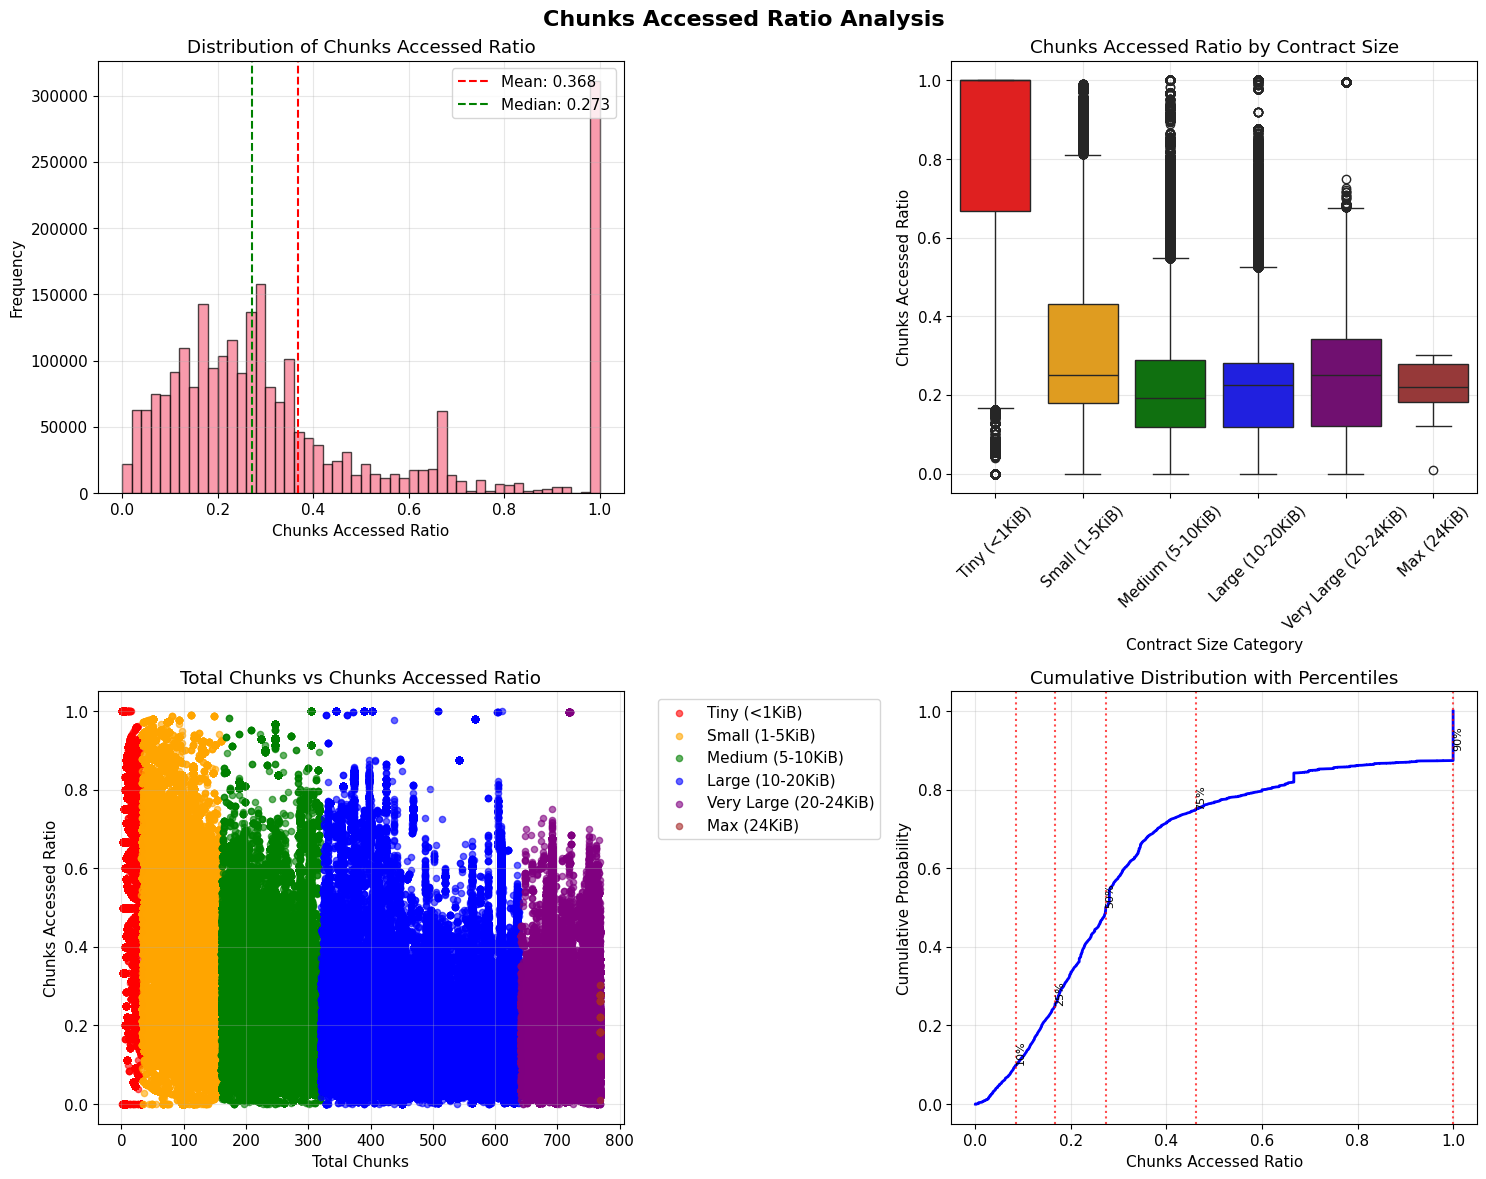


KEY INSIGHTS - Chunks Accessed Ratio:
• Average proportion of chunks accessed: 36.8%
• Median proportion of chunks accessed: 27.3%
• 10th percentile: 8.6%
• 90th percentile: 100.0%
• Contracts with >50% chunks accessed: 569,026 (23.1%)

📊 By Contract Size:
• Tiny (<1KiB): 493,872 contracts, avg 82.4%, median 100.0%
• Small (1-5KiB): 622,277 contracts, avg 31.7%, median 25.0%
• Medium (5-10KiB): 389,900 contracts, avg 21.9%, median 19.2%
• Large (10-20KiB): 556,996 contracts, avg 22.3%, median 22.5%
• Very Large (20-24KiB): 397,220 contracts, avg 23.3%, median 25.1%
• Max (24KiB): 56 contracts, avg 22.6%, median 22.1%


In [175]:
# Analysis of chunks accessed ratio
chunks_ratio_stats = df_analysis['chunks_accessed_ratio'].describe()
print("Chunks Accessed Ratio Statistics:")
print(chunks_ratio_stats)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Chunks Accessed Ratio Analysis', fontsize=16, fontweight='bold')

# Histogram
axes[0,0].hist(df_analysis['chunks_accessed_ratio'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].axvline(chunks_ratio_stats['mean'], color='red', linestyle='--', label=f'Mean: {chunks_ratio_stats["mean"]:.3f}')
axes[0,0].axvline(chunks_ratio_stats['50%'], color='green', linestyle='--', label=f'Median: {chunks_ratio_stats["50%"]:.3f}')
axes[0,0].set_xlabel('Chunks Accessed Ratio')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Chunks Accessed Ratio')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Colored box plot by contract size using seaborn
sns.boxplot(data=df_analysis, x='size_category', y='chunks_accessed_ratio', 
            palette=['red', 'orange', 'green', 'blue', 'purple', 'brown'],
            ax=axes[0,1])
axes[0,1].set_title('Chunks Accessed Ratio by Contract Size')
axes[0,1].set_xlabel('Contract Size Category')
axes[0,1].set_ylabel('Chunks Accessed Ratio')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Scatter plot with color coding by size
size_colors = {size_category_labels[0]: 'red', size_category_labels[1]: 'orange', size_category_labels[2]: 'green', 
               size_category_labels[3]: 'blue', size_category_labels[4]: 'purple', size_category_labels[5]: 'brown'}
for size_cat, color in size_colors.items():
    mask = df_analysis['size_category'] == size_cat
    if mask.any():
        axes[1,0].scatter(df_analysis[mask]['total_chunks'], 
                         df_analysis[mask]['chunks_accessed_ratio'], 
                         alpha=0.6, label=size_cat, color=color, s=20)

axes[1,0].set_xlabel('Total Chunks')
axes[1,0].set_ylabel('Chunks Accessed Ratio')
axes[1,0].set_title('Total Chunks vs Chunks Accessed Ratio')
axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,0].grid(True, alpha=0.3)

# Cumulative distribution with percentile markers
sorted_chunk_ratios = np.sort(df_analysis['chunks_accessed_ratio'])
y_values = np.arange(1, len(sorted_chunk_ratios) + 1) / len(sorted_chunk_ratios)
axes[1,1].plot(sorted_chunk_ratios, y_values, linewidth=2, color='blue')

# Add percentile markers
percentiles = [10, 25, 50, 75, 90]
for p in percentiles:
    val = np.percentile(df_analysis['chunks_accessed_ratio'], p)
    axes[1,1].axvline(val, color='red', linestyle=':', alpha=0.7)
    axes[1,1].text(val, p/100, f'{p}%', rotation=90, verticalalignment='bottom', fontsize=8)

axes[1,1].set_xlabel('Chunks Accessed Ratio')
axes[1,1].set_ylabel('Cumulative Probability')
axes[1,1].set_title('Cumulative Distribution with Percentiles')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Enhanced insights with contract size breakdown
print(f"\nKEY INSIGHTS - Chunks Accessed Ratio:")
print(f"• Average proportion of chunks accessed: {chunks_ratio_stats['mean']:.1%}")
print(f"• Median proportion of chunks accessed: {chunks_ratio_stats['50%']:.1%}")
print(f"• 10th percentile: {np.percentile(df_analysis['chunks_accessed_ratio'], 10):.1%}")
print(f"• 90th percentile: {np.percentile(df_analysis['chunks_accessed_ratio'], 90):.1%}")
print(f"• Contracts with >50% chunks accessed: {(df_analysis['chunks_accessed_ratio'] > 0.5).sum():,} ({(df_analysis['chunks_accessed_ratio'] > 0.5).mean():.1%})")

# Size-specific insights
print(f"\n📊 By Contract Size:")
size_summary = df_analysis.groupby('size_category')['chunks_accessed_ratio'].agg(['count', 'mean', 'median']).round(3)
for size_cat in size_category_labels:
    if size_cat in size_summary.index:
        count = size_summary.loc[size_cat, 'count']
        mean_ratio = size_summary.loc[size_cat, 'mean']
        median_ratio = size_summary.loc[size_cat, 'median']
        print(f"• {size_cat}: {count:,} contracts, avg {mean_ratio:.1%}, median {median_ratio:.1%}")

### Question 3: How do code operations affect access patterns?

QUESTION 3: Impact of Code Operations on Access Patterns
Note: Each code operation accesses the ENTIRE bytecode (all chunks)

COMPARISON: Original vs Code-Operations-Adjusted Access Ratios
------------------------------------------------------------
BYTES ACCESS RATIOS:
• Original average: 30.0%
• Adjusted average (considering code ops): 59.0%
• Increase due to code ops: 29.0%

CHUNKS ACCESS RATIOS:
• Original average: 36.8%
• Adjusted average (considering code ops): 63.0%
• Increase due to code ops: 26.2%

IMPACT BY CONTRACT SIZE CATEGORY:
----------------------------------------
Tiny (<1KiB):
  • 15.3% have code operations
  • Bytes ratio: 77.9% → 84.8% (+6.9%)
  • Chunks ratio: 82.4% → 88.1% (+5.7%)
Small (1-5KiB):
  • 39.0% have code operations
  • Bytes ratio: 21.7% → 51.5% (+29.8%)
  • Chunks ratio: 31.7% → 57.6% (+25.9%)
Medium (5-10KiB):
  • 41.4% have code operations
  • Bytes ratio: 15.0% → 49.5% (+34.5%)
  • Chunks ratio: 21.9% → 53.2% (+31.3%)
Large (10-20KiB):
  • 49.4% ha

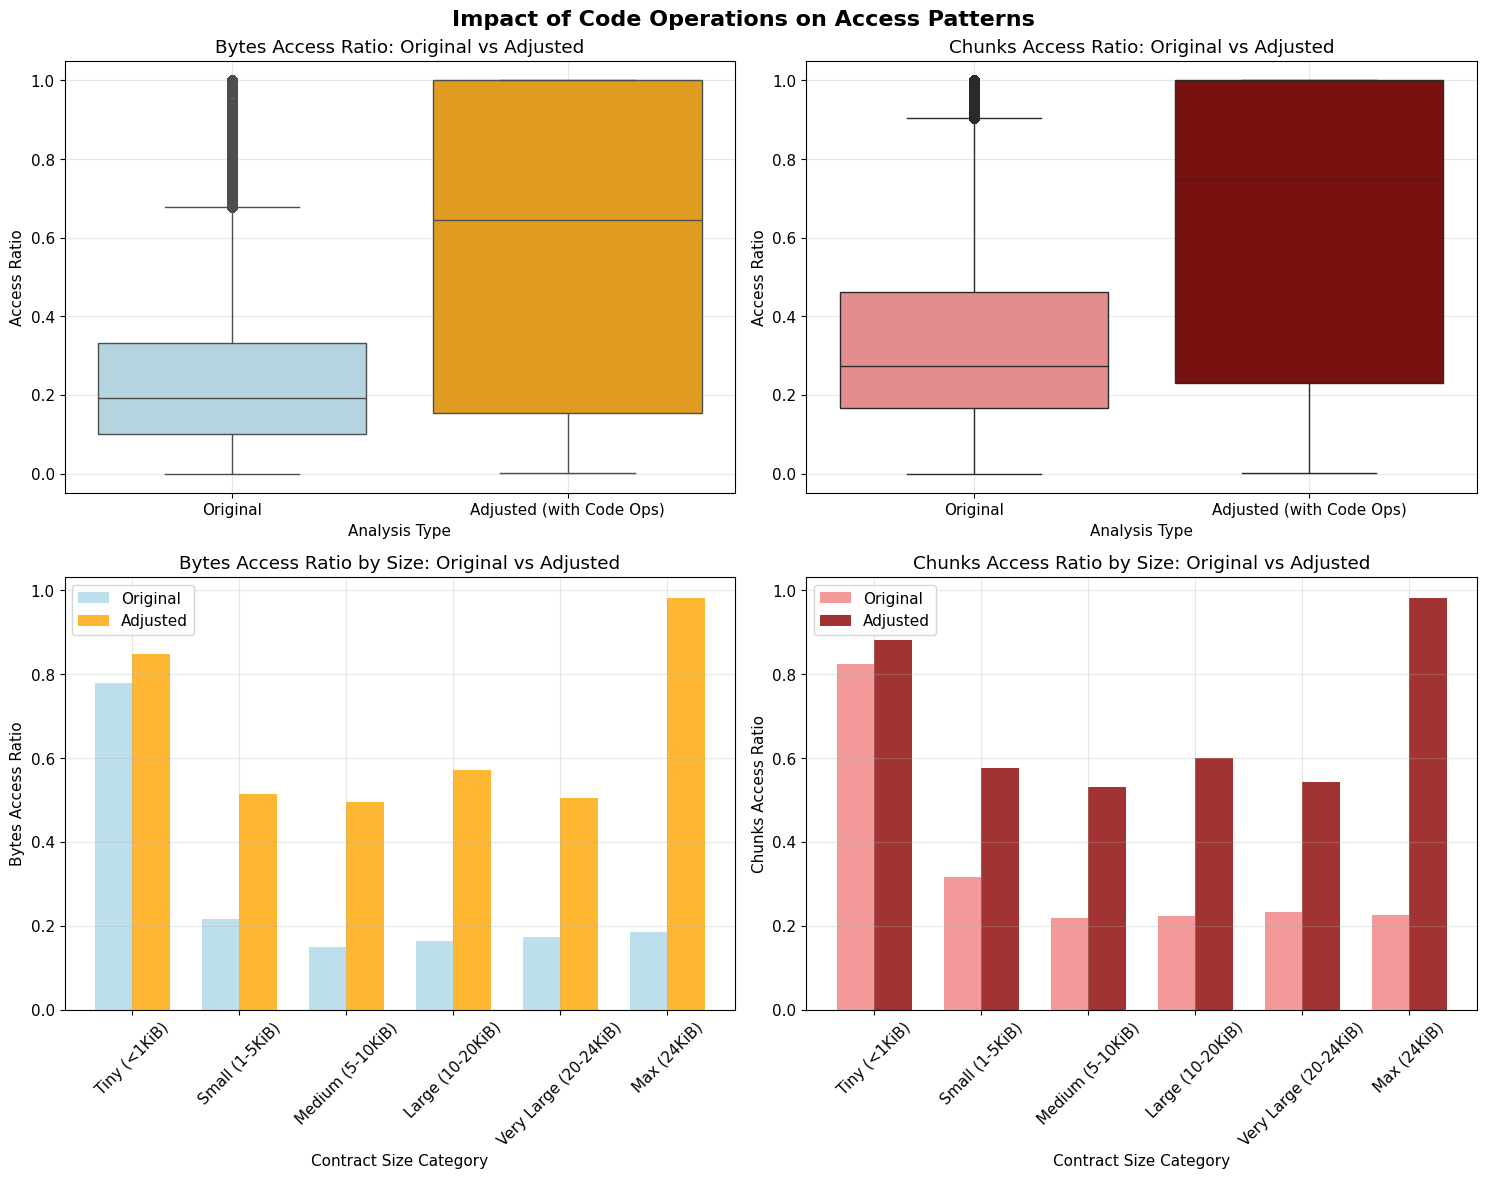


🔍 KEY INSIGHTS - Code Operations Impact:
• Contracts with code operations effectively have 100% access ratios
• 37.1% of contracts have code operations
• Code operations increase average bytes access from 30.0% to 59.0%
• Code operations increase average chunks access from 36.8% to 63.0%
• The impact varies significantly by contract size

EFFICIENCY RECLASSIFICATION (considering code operations):
• High efficiency (>50% access): 1,309,685 contracts (53.2%)
• Medium efficiency (20-50% access): 392,014 contracts (15.9%)
• Low efficiency (<20% access): 758,622 contracts (30.8%)


In [172]:
# Question 3: Impact of Code Operations on Access Patterns
# Each code operation (EXTCODESIZE, EXTCODECOPY, EXTCODEHASH, CODECOPY, CODESIZE) accesses the entire bytecode

print("QUESTION 3: Impact of Code Operations on Access Patterns")
print("="*70)
print("Note: Each code operation accesses the ENTIRE bytecode (all chunks)")
print()

# Calculate adjusted access ratios considering code operations
# If code_ops_count > 0, then effectively ALL bytes and chunks are accessed at least once
df_analysis['adjusted_bytes_ratio'] = df_analysis.apply(
    lambda row: 1.0 if row['code_ops_count'] > 0 else row['bytes_accessed_ratio'], axis=1
)

df_analysis['adjusted_chunks_ratio'] = df_analysis.apply(
    lambda row: 1.0 if row['code_ops_count'] > 0 else row['chunks_accessed_ratio'], axis=1
)

# Compare original vs adjusted ratios
print("COMPARISON: Original vs Code-Operations-Adjusted Access Ratios")
print("-" * 60)

original_bytes_mean = df_analysis['bytes_accessed_ratio'].mean()
adjusted_bytes_mean = df_analysis['adjusted_bytes_ratio'].mean()
original_chunks_mean = df_analysis['chunks_accessed_ratio'].mean()
adjusted_chunks_mean = df_analysis['adjusted_chunks_ratio'].mean()

print(f"BYTES ACCESS RATIOS:")
print(f"• Original average: {original_bytes_mean:.1%}")
print(f"• Adjusted average (considering code ops): {adjusted_bytes_mean:.1%}")
print(f"• Increase due to code ops: {adjusted_bytes_mean - original_bytes_mean:.1%}")

print(f"\nCHUNKS ACCESS RATIOS:")
print(f"• Original average: {original_chunks_mean:.1%}")
print(f"• Adjusted average (considering code ops): {adjusted_chunks_mean:.1%}")
print(f"• Increase due to code ops: {adjusted_chunks_mean - original_chunks_mean:.1%}")

# Analysis by contract size
print(f"\nIMPACT BY CONTRACT SIZE CATEGORY:")
print("-" * 40)

size_comparison = df_analysis.groupby('size_category').agg({
    'bytes_accessed_ratio': 'mean',
    'adjusted_bytes_ratio': 'mean',
    'chunks_accessed_ratio': 'mean', 
    'adjusted_chunks_ratio': 'mean',
    'code_ops_count': ['mean', lambda x: (x > 0).mean()]
}).round(3)

size_comparison.columns = ['Original_Bytes', 'Adjusted_Bytes', 'Original_Chunks', 'Adjusted_Chunks', 'Avg_Code_Ops', 'Pct_With_Code_Ops']

for size_cat in size_category_labels:
    if size_cat in size_comparison.index:
        orig_bytes = size_comparison.loc[size_cat, 'Original_Bytes']
        adj_bytes = size_comparison.loc[size_cat, 'Adjusted_Bytes']
        orig_chunks = size_comparison.loc[size_cat, 'Original_Chunks']
        adj_chunks = size_comparison.loc[size_cat, 'Adjusted_Chunks']
        pct_with_ops = size_comparison.loc[size_cat, 'Pct_With_Code_Ops']
        
        bytes_increase = adj_bytes - orig_bytes
        chunks_increase = adj_chunks - orig_chunks
        
        print(f"{size_cat}:")
        print(f"  • {pct_with_ops:.1%} have code operations")
        print(f"  • Bytes ratio: {orig_bytes:.1%} → {adj_bytes:.1%} (+{bytes_increase:.1%})")
        print(f"  • Chunks ratio: {orig_chunks:.1%} → {adj_chunks:.1%} (+{chunks_increase:.1%})")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Impact of Code Operations on Access Patterns', fontsize=16, fontweight='bold')

# Before vs After comparison - Bytes (colored box plots)
# Create separate datasets for seaborn
bytes_comparison_df = pd.DataFrame({
    'Access_Ratio': list(df_analysis['bytes_accessed_ratio']) + list(df_analysis['adjusted_bytes_ratio']),
    'Type': ['Original'] * len(df_analysis) + ['Adjusted (with Code Ops)'] * len(df_analysis)
})

sns.boxplot(data=bytes_comparison_df, x='Type', y='Access_Ratio', 
            palette=['lightblue', 'orange'], ax=axes[0,0])
axes[0,0].set_title('Bytes Access Ratio: Original vs Adjusted')
axes[0,0].set_xlabel('Analysis Type')
axes[0,0].set_ylabel('Access Ratio')
axes[0,0].grid(True, alpha=0.3)

# Before vs After comparison - Chunks (colored box plots)
chunks_comparison_df = pd.DataFrame({
    'Access_Ratio': list(df_analysis['chunks_accessed_ratio']) + list(df_analysis['adjusted_chunks_ratio']),
    'Type': ['Original'] * len(df_analysis) + ['Adjusted (with Code Ops)'] * len(df_analysis)
})

sns.boxplot(data=chunks_comparison_df, x='Type', y='Access_Ratio', 
            palette=['lightcoral', 'darkred'], ax=axes[0,1])
axes[0,1].set_title('Chunks Access Ratio: Original vs Adjusted')
axes[0,1].set_xlabel('Analysis Type')
axes[0,1].set_ylabel('Access Ratio')
axes[0,1].grid(True, alpha=0.3)

# Impact by contract size - Bytes
size_means_orig = df_analysis.groupby('size_category')['bytes_accessed_ratio'].mean().reindex(size_category_labels)
size_means_adj = df_analysis.groupby('size_category')['adjusted_bytes_ratio'].mean().reindex(size_category_labels)

x_pos = range(len(size_category_labels))
width = 0.35
axes[1,0].bar([x - width/2 for x in x_pos], size_means_orig, width, label='Original', alpha=0.8, color='lightblue')
axes[1,0].bar([x + width/2 for x in x_pos], size_means_adj, width, label='Adjusted', alpha=0.8, color='orange')
axes[1,0].set_xlabel('Contract Size Category')
axes[1,0].set_ylabel('Bytes Access Ratio')
axes[1,0].set_title('Bytes Access Ratio by Size: Original vs Adjusted')
axes[1,0].set_xticks(x_pos)
axes[1,0].set_xticklabels(size_category_labels, rotation=45)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Impact by contract size - Chunks
size_means_orig_chunks = df_analysis.groupby('size_category')['chunks_accessed_ratio'].mean().reindex(size_category_labels)
size_means_adj_chunks = df_analysis.groupby('size_category')['adjusted_chunks_ratio'].mean().reindex(size_category_labels)

axes[1,1].bar([x - width/2 for x in x_pos], size_means_orig_chunks, width, label='Original', alpha=0.8, color='lightcoral')
axes[1,1].bar([x + width/2 for x in x_pos], size_means_adj_chunks, width, label='Adjusted', alpha=0.8, color='darkred')
axes[1,1].set_xlabel('Contract Size Category')
axes[1,1].set_ylabel('Chunks Access Ratio')
axes[1,1].set_title('Chunks Access Ratio by Size: Original vs Adjusted')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels(size_category_labels, rotation=45)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key insights
print(f"\n🔍 KEY INSIGHTS - Code Operations Impact:")
print(f"• Contracts with code operations effectively have 100% access ratios")
print(f"• {(df_analysis['code_ops_count'] > 0).mean():.1%} of contracts have code operations")
print(f"• Code operations increase average bytes access from {original_bytes_mean:.1%} to {adjusted_bytes_mean:.1%}")
print(f"• Code operations increase average chunks access from {original_chunks_mean:.1%} to {adjusted_chunks_mean:.1%}")
print(f"• The impact varies significantly by contract size")

# Efficiency reclassification
high_eff_adj = (df_analysis['adjusted_bytes_ratio'] > 0.5) & (df_analysis['adjusted_chunks_ratio'] > 0.5)
medium_eff_adj = ((df_analysis['adjusted_bytes_ratio'] > 0.2) & (df_analysis['adjusted_chunks_ratio'] > 0.2)) & ~high_eff_adj
low_eff_adj = ~high_eff_adj & ~medium_eff_adj

print(f"\nEFFICIENCY RECLASSIFICATION (considering code operations):")
print(f"• High efficiency (>50% access): {high_eff_adj.sum():,} contracts ({high_eff_adj.mean():.1%})")
print(f"• Medium efficiency (20-50% access): {medium_eff_adj.sum():,} contracts ({medium_eff_adj.mean():.1%})")
print(f"• Low efficiency (<20% access): {low_eff_adj.sum():,} contracts ({low_eff_adj.mean():.1%})")

### Question 4: Block-level Analysis

QUESTION 4: Block-level Bytecode Utilization Analysis
Focus: Efficiency classification with and without code operation impact

1. BLOCK-LEVEL EFFICIENCY OVERVIEW:
----------------------------------------
• Blocks analyzed: 9,993
• Average bytes efficiency (original): 16.8%
• Average bytes efficiency (adjusted): 52.1%
• Average chunks efficiency (original): 23.0%
• Average chunks efficiency (adjusted): 55.7%

2. BYTES EFFICIENCY CLASSIFICATION:
----------------------------------------
• Low efficiency blocks:
  - Original: 9,818 (98.2%)
  - Adjusted: 2 (0.0%)
• Medium efficiency blocks:
  - Original: 175 (1.8%)
  - Adjusted: 2,983 (29.9%)
• High efficiency blocks:
  - Original: 0 (0.0%)
  - Adjusted: 7,008 (70.1%)

3. CHUNKS EFFICIENCY CLASSIFICATION:
----------------------------------------
• Low efficiency blocks:
  - Original: 564 (5.6%)
  - Adjusted: 1 (0.0%)
• Medium efficiency blocks:
  - Original: 9,429 (94.4%)
  - Adjusted: 1,030 (10.3%)
• High efficiency blocks:
  - Original: 0

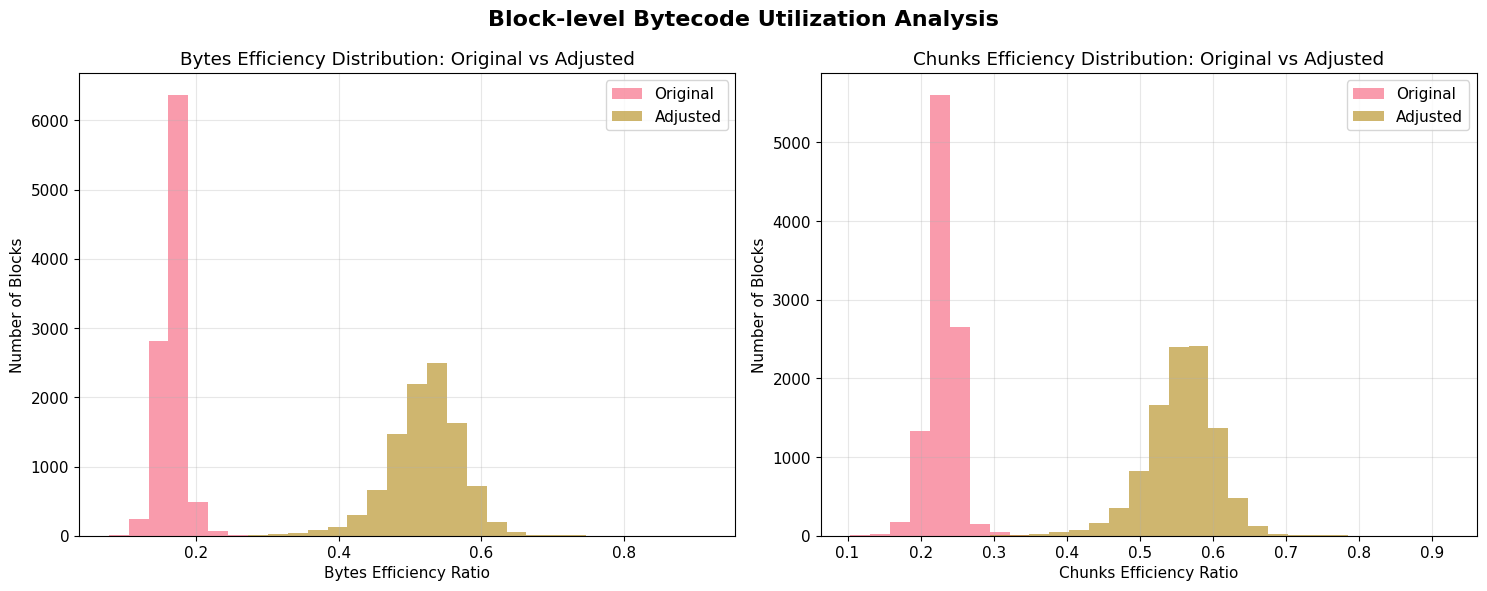


🔍 KEY INSIGHTS - Block-level Bytecode Utilization:
• Code operations significantly shift efficiency classifications
• 9991 blocks see >10% bytes efficiency improvement
• 9990 blocks see >10% chunks efficiency improvement
• Efficiency patterns show clear impact of code operation density per block
• Both bytes and chunks efficiency follow similar patterns but with different magnitudes


In [173]:
# Question 4: Block-level Bytecode Utilization Analysis
print("QUESTION 4: Block-level Bytecode Utilization Analysis")
print("="*70)
print("Focus: Efficiency classification with and without code operation impact")
print()

# Basic block-level aggregations
block_analysis = df_analysis.groupby('block_number').agg({
    'address': ['count', 'nunique'],  # Total calls vs unique contracts
    'bytecode_size': 'sum',
    'bytes_count': 'sum',
    'chunks_count': 'sum', 
    'total_chunks': 'sum',
    'bytes_accessed_ratio': 'mean',
    'chunks_accessed_ratio': 'mean',
    'adjusted_bytes_ratio': 'mean',
    'adjusted_chunks_ratio': 'mean',
    'code_ops_count': 'sum'
}).round(4)

# Flatten column names
block_analysis.columns = [
    'Total_Contract_Calls', 'Unique_Contracts', 'Total_Bytecode_Size',
    'Total_Bytes_Accessed', 'Total_Chunks_Accessed', 'Total_Chunks_Available',
    'Avg_Bytes_Ratio', 'Avg_Chunks_Ratio', 
    'Avg_Adj_Bytes_Ratio', 'Avg_Adj_Chunks_Ratio', 'Total_Code_Ops'
]

# Calculate block-level efficiency metrics
block_analysis['Bytes_Efficiency_Original'] = block_analysis['Total_Bytes_Accessed'] / block_analysis['Total_Bytecode_Size']
block_analysis['Chunks_Efficiency_Original'] = block_analysis['Total_Chunks_Accessed'] / block_analysis['Total_Chunks_Available']

# For adjusted efficiency, we need to calculate how much would be accessed if code ops access everything
adjusted_bytes_accessed = df_analysis.groupby('block_number').apply(
    lambda group: sum(row['bytecode_size'] if row['code_ops_count'] > 0 else row['bytes_count'] 
                     for _, row in group.iterrows())
).reindex(block_analysis.index)

adjusted_chunks_accessed = df_analysis.groupby('block_number').apply(
    lambda group: sum(row['total_chunks'] if row['code_ops_count'] > 0 else row['chunks_count'] 
                     for _, row in group.iterrows())
).reindex(block_analysis.index)

block_analysis['Bytes_Efficiency_Adjusted'] = adjusted_bytes_accessed / block_analysis['Total_Bytecode_Size']
block_analysis['Chunks_Efficiency_Adjusted'] = adjusted_chunks_accessed / block_analysis['Total_Chunks_Available']

# Classification thresholds
HIGH_THRESHOLD = 0.5
LOW_THRESHOLD = 0.2

# Efficiency Classifications - Original (without code ops impact)
block_analysis['Bytes_Class_Original'] = pd.cut(
    block_analysis['Bytes_Efficiency_Original'],
    bins=[0, LOW_THRESHOLD, HIGH_THRESHOLD, 1.0],
    labels=['Low', 'Medium', 'High'],
    include_lowest=True
)

block_analysis['Chunks_Class_Original'] = pd.cut(
    block_analysis['Chunks_Efficiency_Original'],
    bins=[0, LOW_THRESHOLD, HIGH_THRESHOLD, 1.0],
    labels=['Low', 'Medium', 'High'],
    include_lowest=True
)

# Efficiency Classifications - Adjusted (with code ops impact)
block_analysis['Bytes_Class_Adjusted'] = pd.cut(
    block_analysis['Bytes_Efficiency_Adjusted'],
    bins=[0, LOW_THRESHOLD, HIGH_THRESHOLD, 1.0],
    labels=['Low', 'Medium', 'High'],
    include_lowest=True
)

block_analysis['Chunks_Class_Adjusted'] = pd.cut(
    block_analysis['Chunks_Efficiency_Adjusted'],
    bins=[0, LOW_THRESHOLD, HIGH_THRESHOLD, 1.0],
    labels=['Low', 'Medium', 'High'],
    include_lowest=True
)

print("1. BLOCK-LEVEL EFFICIENCY OVERVIEW:")
print("-" * 40)
print(f"• Blocks analyzed: {len(block_analysis):,}")
print(f"• Average bytes efficiency (original): {block_analysis['Bytes_Efficiency_Original'].mean():.1%}")
print(f"• Average bytes efficiency (adjusted): {block_analysis['Bytes_Efficiency_Adjusted'].mean():.1%}")
print(f"• Average chunks efficiency (original): {block_analysis['Chunks_Efficiency_Original'].mean():.1%}")
print(f"• Average chunks efficiency (adjusted): {block_analysis['Chunks_Efficiency_Adjusted'].mean():.1%}")

print(f"\n2. BYTES EFFICIENCY CLASSIFICATION:")
print("-" * 40)
bytes_orig_counts = block_analysis['Bytes_Class_Original'].value_counts()
bytes_adj_counts = block_analysis['Bytes_Class_Adjusted'].value_counts()

for category in ['Low', 'Medium', 'High']:
    orig_count = bytes_orig_counts.get(category, 0)
    adj_count = bytes_adj_counts.get(category, 0)
    orig_pct = orig_count / len(block_analysis) * 100
    adj_pct = adj_count / len(block_analysis) * 100
    print(f"• {category} efficiency blocks:")
    print(f"  - Original: {orig_count:,} ({orig_pct:.1f}%)")
    print(f"  - Adjusted: {adj_count:,} ({adj_pct:.1f}%)")

print(f"\n3. CHUNKS EFFICIENCY CLASSIFICATION:")
print("-" * 40)
chunks_orig_counts = block_analysis['Chunks_Class_Original'].value_counts()
chunks_adj_counts = block_analysis['Chunks_Class_Adjusted'].value_counts()

for category in ['Low', 'Medium', 'High']:
    orig_count = chunks_orig_counts.get(category, 0)
    adj_count = chunks_adj_counts.get(category, 0)
    orig_pct = orig_count / len(block_analysis) * 100
    adj_pct = adj_count / len(block_analysis) * 100
    print(f"• {category} efficiency blocks:")
    print(f"  - Original: {orig_count:,} ({orig_pct:.1f}%)")
    print(f"  - Adjusted: {adj_count:,} ({adj_pct:.1f}%)")

print(f"\n4. CODE OPERATIONS IMPACT:")
print("-" * 40)
blocks_with_code_ops = (block_analysis['Total_Code_Ops'] > 0).sum()
print(f"• Blocks with code operations: {blocks_with_code_ops:,} ({blocks_with_code_ops/len(block_analysis):.1%})")
print(f"• Average code operations per block: {block_analysis['Total_Code_Ops'].mean():.1f}")

# Calculate efficiency improvements due to code ops
bytes_improvement = block_analysis['Bytes_Efficiency_Adjusted'] - block_analysis['Bytes_Efficiency_Original']
chunks_improvement = block_analysis['Chunks_Efficiency_Adjusted'] - block_analysis['Chunks_Efficiency_Original']

print(f"• Average bytes efficiency improvement: {bytes_improvement.mean():.1%}")
print(f"• Average chunks efficiency improvement: {chunks_improvement.mean():.1%}")

# Create focused visualizations (adjusted to 1x2 layout since 4 plots were removed)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Block-level Bytecode Utilization Analysis', fontsize=16, fontweight='bold')

# 1. Efficiency distribution comparison - Bytes
efficiency_comparison_bytes = pd.DataFrame({
    'Original': block_analysis['Bytes_Efficiency_Original'],
    'Adjusted': block_analysis['Bytes_Efficiency_Adjusted']
})

efficiency_comparison_bytes.plot(kind='hist', alpha=0.7, bins=30, ax=axes[0])
axes[0].set_xlabel('Bytes Efficiency Ratio')
axes[0].set_ylabel('Number of Blocks')
axes[0].set_title('Bytes Efficiency Distribution: Original vs Adjusted')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Efficiency distribution comparison - Chunks
efficiency_comparison_chunks = pd.DataFrame({
    'Original': block_analysis['Chunks_Efficiency_Original'],
    'Adjusted': block_analysis['Chunks_Efficiency_Adjusted']
})

efficiency_comparison_chunks.plot(kind='hist', alpha=0.7, bins=30, ax=axes[1])
axes[1].set_xlabel('Chunks Efficiency Ratio')
axes[1].set_ylabel('Number of Blocks')
axes[1].set_title('Chunks Efficiency Distribution: Original vs Adjusted')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🔍 KEY INSIGHTS - Block-level Bytecode Utilization:")
print(f"• Code operations significantly shift efficiency classifications")
print(f"• {(bytes_improvement > 0.1).sum()} blocks see >10% bytes efficiency improvement")
print(f"• {(chunks_improvement > 0.1).sum()} blocks see >10% chunks efficiency improvement")
print(f"• Efficiency patterns show clear impact of code operation density per block")
print(f"• Both bytes and chunks efficiency follow similar patterns but with different magnitudes")